# Simulation functions

In [14]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
import jax.numpy as jnp
m = bi(platform='cpu')
import BI.NBDA as NBDA
import numpy as np
import igraph as ig

jax.local_device_count 32


## Covariates simulation

In [15]:
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import numpy as np
jnp.set_printoptions(precision=2,linewidth=200)

def symmetrize(array):
    return (array + array.T) / 2
    
def sim_grp_equal_prob(G, N):
    # Create a 1D array of ones with length G
    ones = jnp.ones((G,))

    # Normalize to get equal probabilities
    equal_probs = ones / G

    # Generate multinomial probabilities
    grp_prob = m.dist.multinomialprobs(equal_probs, 1, sample=True, shape=(N,))

    # Use vmap with jnp.argmax to sample indices
    return vmap(jnp.argmax)(grp_prob)

def sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3])):
    return [sim_grp_equal_prob(gByGrp[i],N) for i in range(len(gByGrp))]

def create_random_network(n, rate = 0.2, seed=0):
    """
    Create a random network adjacency matrix using the Erdős-Rényi model.
    
    Parameters:
        n (int): Number of nodes in the network.
        rate (float): ate parameter (mean of the distribution), must be >= 0.
        seed (int): Random seed for reproducibility.
        
    Returns:
        jax.numpy.ndarray: Adjacency matrix of the generated random network.
    """
    # Set the random seed for reproducibility
    key = jax.random.PRNGKey(seed)
    
    upper_tri = jax.random.poisson(key,lam = rate,  shape = (n, n))
    lower_tri = upper_tri
    
    # Make the matrix symmetric to represent an undirected graph
    m = upper_tri + lower_tri
    m = m.at[jnp.diag_indices(m.shape[0])].set(0)
    return m

def viz_network(network, block1 = None):
    
    # Convert the input data to NumPy arrays
    adj_matrix_np = np.array(network)
    if block1 is not None:
        block1_np = np.array(block1)
    else:
        block1_np = None


    # Create an igraph graph from the adjacency matrix
    G = ig.Graph.Adjacency((adj_matrix_np > 0).tolist())

    # Add weights to the edges if the adjacency matrix contains weights
    G.es['weight'] = adj_matrix_np[adj_matrix_np.nonzero()] / 4

    # Define the layout
    layout = G.layout_kamada_kawai()
    scale_factor = 20
    layout = [tuple(coord * scale_factor for coord in point) for point in layout]

    # Map the color array to specific colors
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    if block1_np is not None:
        node_colors = [color_map[block] for block in block1_np]
    else:
        node_colors = ['gray'] * len(G.vs)

    edge_colors = []
    for edge in G.es:
        # 'edge.source' gives the emitter node index for directed graphs.
        edge_colors.append(node_colors[edge.source])
    #G.es["color"] = edge_colors

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ig.plot(G, layout=layout, 
            vertex_size=10, vertex_color=node_colors, 
            edge_width=G.es['weight'], target=ax,
            #edge_color=G.es["color"],
            edge_arrow_size=4, edge_curved = 0.2)

    # Display the plot
    plt.show()

def create_covariates(N=50, times=00,
b_ij_mean1 = 0.5, b_ij_sd1 = 0.5, b_ii_mean1 = 0.7, b_ii_sd1 = 1.5,
b_ij_mean = 0.02, b_ij_sd = 0.1, b_ii_mean = 0.4, b_ii_sd = 0.1,
print_network = False):
    # Network-----------------------------------------------------------
    ## Block ---------------------------------------
    blocks = sim_grp(N, Ngrp=2,gByGrp=jnp.array([1,3]))
    block0=blocks[0]
    block1=blocks[1]
    B0 = m.net.block_model(block0,1, b_ij_mean = b_ij_mean1, b_ij_sd = b_ij_sd1, b_ii_mean = b_ii_mean1, b_ii_sd = b_ii_sd1,sample=True)
    B1 = m.net.block_model(block1,3, b_ij_mean = b_ij_mean, b_ij_sd = b_ij_sd, b_ii_mean = b_ii_mean, b_ii_sd = b_ii_sd,sample=True)

    ### SR shape =  N individuals---------------------------------------
    focal_individual_predictors = m.dist.binomial(total_count = 1, logits = 0.5, sample=True, shape=(1,N)) # Fixed covariate
    target_individual_predictors=focal_individual_predictors
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors,
                                 s_mu= -0.5, s_sd= 0.1, r_mu= 0, r_sd= 0.2,
                                 sample=True)

    ## Dyadic shape = N dyads-------------------------------------- 
    covDF = create_random_network(N, rate=0.1) # Fixed dyadic covariate
    covDF = jnp.where(covDF > 0, 1, 0) 
    dyadic_predictors =m.net.mat_to_edgl(covDF)
    dr = m.net.dyadic_effect(dyadic_predictors=dyadic_predictors, shape=(N,), sample=True)

    #network=bi.net.edgl_to_mat(bi.poisson(jnp.exp(B0 + B1 + sr + dr),sample=True ), N)
    network=m.net.edgl_to_mat(m.dist.binomial(total_count = 20, logits = B0 + B1 + sr + dr,sample=True ), N)
    network = network/20
    if print_network:
        viz_network(network, block1)

    # Covariates-----------------------------------------------------------
    time = jnp.arange(0,times)
    covF = focal_individual_predictors # Fixed covariate
    jnp.tile(covF[0,:], (times, 1)).T.shape

    # Time-varying covariate

    covV = m.dist.poisson(5, sample=True, shape=(N,)) # time-varying covariate
    covV = vmap(lambda x: covV + x)(time).T
    covDV = vmap(lambda x: create_random_network(N, rate=0.3, seed=x))(time).transpose(1,2,0) # Time-varying dyadic covariate
    covDF = jnp.stack([covDF] * times, axis=2)

    return {
        'covF': covF[0,:],
        'covV': covV,
        'network': network,
        'covDF': covDF,
        'covDV': covDV
    }

def heatmap(array):
    # Convert to NumPy for Matplotlib
    data_np = jnp.array(array)  # Alternatively, use `data.to_numpy()`

    # Plot heatmap
    plt.imshow(data_np, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.show()


To create covaraites just run ```covariates_data = create_covariates(N=N, times=times)```

## Diffusion simulations


In [16]:
import ipdb
import jax
@jax.jit
def inv_logit2(x):
    """
    Modified inverse logit function scaling between 0 and 1.
    """
    return (m.link.inv_logit(x) - 0.5) * 2


In [17]:
import random as random2

def diffusion(data, alpha_social, alpha_asocial):
    D_social = data.D_social
    D_asocial = data.D_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = m.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(m.dist.binomial(total_count=jnp.ones(theta.shape[0], dtype=int), probs = theta, sample=True, seed = random2.randint(0,10000)))

    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)        
        attention_weigthed_network = phi*data.network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))


        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight

        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, m.dist.binomial(total_count=jnp.ones(p.shape[0], dtype=int),probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed

## NBDA Model
This model should adapt to NBDA class stored information.
In order to implement time varying coefficients we need to define a function that takes the $V$ covariates and $T$ time points and returns the coefficients. All coefficents of the model need this structure.

### Model without covariates

In [18]:
def model0(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = m.dist.normal(0, 3, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = m.dist.normal(0, 3, shape = (1,), sample=False, name='alpha_asoc')

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)


    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

In [19]:
import jax.numpy as jnp
from jax import lax, jit
import numpyro

def model2(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_asoc')
    
    # Initial timestep (t=0) - Asocial learning
    R_asocial_0 = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    lk = lk.at[:,0].set(bi.link.inv_logit(R_asocial_0) )
    
    # Define a function for a single timestep computation
    def timestep_fn(t, lk_acc):
        # Social learning
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)  # Using logistic directly if possible
        attention_weigthed_network = phi * network[:,:,t,0]
        social_influence_weight =  inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        
        # Asocial learning
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)  # Using logistic directly if possible

        # Update lk for timestep t
        lk_new = lk_acc.at[:,t].set(
            jnp.where(
                status[:, t-1][:,0] == 1, 
                jnp.nan, 
                theta + (1-theta)*social_influence_weight[:,0]
                )
            )
        
        return lk_new
    
    # Use lax.fori_loop for better performance than Python loop
    lk = lax.fori_loop(
        1, T,  # Loop from 1 to T-1
        lambda i, lk_acc: timestep_fn(i, lk_acc),
        lk
    )

    
    # Sample with mask
    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])
    
    return lk

## Plot posterior distribution and simulated data

In [20]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random as random2
import math

def generate_random_hex_color():
    number = random2.randint(0, 0xFFFFFF)
    return f"#{number:06X}"

def plot_distributions(posteriors , true_values = dict(alpha_asoc=-5, alpha_soc=1), by_param=False):
    parameters = list(posteriors.keys())
    
    if by_param:
        # Calculate number of rows and columns needed
        n_params = 0
        newParam = []
        for a in parameters:
            if posteriors[a].size > 1:
                n_params += 1
                newParam.append(a)

        parameters = newParam
        
        # Limit columns to between 1 and 3
        if n_params <= 1:
            n_cols = 1
        elif n_params <= 3:
            n_cols = n_params
        else:
            n_cols = 3       

            
        # Calculate number of rows based on n_params and n_cols
        n_rows = math.ceil(n_params / n_cols)
        
        # Create a figure with subplots
        if n_params == 1:
            fig, axes = plt.subplots(1, 1, figsize=(15, 10))
            # Convert single axis to array to make indexing consistent
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
            # Ensure axes is always a 2D array for consistent indexing
            if n_rows == 1:
                axes = axes.reshape(1, -1)
        
        fig.tight_layout()
    else:
        plt.figure(figsize=(10, 6))
    
    legend_handles = []
    
    for param in parameters:
        if by_param:
            # Calculate index for subplot positioning
            idx = parameters.index(param)
            row = idx // n_cols
            col = idx % n_cols
            
            # Access the appropriate subplot
            if n_params == 1:
                ax = axes[0]
            else:
                ax = axes[row, col]
        else:
            ax = plt.gca()

        mean = posteriors[param].mean(axis=0)
        std = posteriors[param].std(axis=0)
        
        if mean.shape == ():
            color = generate_random_hex_color()
            
            # Create a histogram to get the distribution data
            n, bins, patches = plt.hist(posteriors[param], bins=50, density=True, alpha=0.0)
            
            # Add true value offset
            n = n + true_values[param]
            density = n
            
            # Center the distribution
            center_in_density = density.mean()
            density_shifted = density - center_in_density
            
            # Scale the distribution
            scale_factor = 0.3
            density_scaled = density_shifted * scale_factor
            
            # Shift to true value position
            density_final = density_scaled + true_values[param]
            
            # Get bin centers
            bin_centers = (bins[1:] + bins[:-1]) / 2
            
            # Plot the distribution
            if by_param:
                ax.plot(n, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            else:
                ax.plot(density_final, bin_centers, color=color)
                ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
            
            # Add legend handle
            legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}")
            legend_handles.append(legend_handle)
            
            # Add labels and title
            ax.set_xlabel(f" True Value of Parameter {param}")
            ax.set_ylabel(f" Posterior distribution of Parameter {param}")
            ax.set_title(f'Distribution of {param}')
            if by_param:
                # Set individual y-axis limits for each subplot
                y_min = min(posteriors[param][:, a])
                y_max = max(posteriors[param][:, a])
                padding = 0.1 * (y_max - y_min)
                ax.set_ylim(y_min - padding, y_max + padding)           
            
            if not by_param:
                ax.grid(False)
        else:
            color = generate_random_hex_color()
            length = len(mean)
            
            for a in range(length):
                color = generate_random_hex_color()
                
                # Create a histogram to get the distribution data
                n, bins, patches = plt.hist(posteriors[param][:, a], bins=50, density=True, alpha=0.0)
                
                # Add true value offset
                n = n + true_values[param][a]
                density = n
                
                # Center the distribution
                center_in_density = density.mean()
                density_shifted = density - center_in_density
                
                # Scale the distribution
                scale_factor = 0.3
                density_scaled = density_shifted * scale_factor
                
                # Shift to true value position
                density_final = density_scaled + true_values[param][a]
                
                # Get bin centers
                bin_centers = (bins[1:] + bins[:-1]) / 2
                
                # Plot the distribution
                if by_param:
                    ax.plot(n, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                else:
                    ax.plot(density_final, bin_centers, color=color)
                    ax.errorbar(true_values[param], mean, color=color, yerr=std, fmt='o')
                
                # Add legend handle
                legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='-', label=f"{param}_{a}")
                legend_handles.append(legend_handle)
                
                # Add labels and title
                ax.set_xlabel(f" True Value of Parameter {param}_{a}")
                ax.set_ylabel(f" Posterior distribution of Parameter {param}_{a}")
                ax.set_title(f'Distribution of {param} ({a})')

                if by_param:
                    # Set individual y-axis limits for each subplot
                    y_min = min(posteriors[param][:, a])
                    y_max = max(posteriors[param][:, a])
                    padding = 0.1 * (y_max - y_min)
                    ax.set_ylim(y_min - padding, y_max + padding)

                if not by_param:
                    ax.grid(False)
    
    if not by_param:
        plt.xlabel(f" True Values ")
        plt.ylabel(f" Posterior distribution")
        plt.grid(False)
        plt.axis('tight')
        plt.legend(handles=legend_handles)
        plt.show()
    else:
        for ax in axes.ravel():
            if not ax.has_data():
                ax.axis('off')
        plt.axis('tight')
        plt.tight_layout()
        plt.show()

# Fro further details on the posterior distributions, we can plot the KDE of each parameter
def kde(array, original_value, name = None, mean = True):
    if mean :
        estimated_mean = array.mean()
    else:
        estimated_mean = jnp.median(array)
    original_value = original_value
    sns.histplot(array, kde=True, bins = 100)
    plt.axvline(original_value, color='r', linestyle='dashed', linewidth=1, label='Simulated value')
    plt.axvline(estimated_mean, color='g', linestyle='dashed', linewidth=1, label='Estimated value')
    plt.xticks([estimated_mean, original_value], 
           [f'{estimated_mean:.2f}', f'{original_value:.2f}'])
    if name is not None:
        plt.title(f'Posterior distribution  vs simulated value for {name}')
    else:
        plt.title(f'Posterior distribution  vs simulated value')
    plt.show()

def params_kde(m, alpha_asocial, alpha_social):
    original_values = [alpha_asocial[0].tolist(), 
                       alpha_social[0].tolist()] + alpha_asocial[1:].tolist() + alpha_social[1:].tolist()
    count = 0
    for k in m.posteriors.keys():
        if m.posteriors[k].shape[1] == 1:
            kde(m.posteriors[k][:,0], original_values[count], name=k)
            plt.close()
            count += 1
        else:
            for i in range(m.posteriors[k].shape[1]):
                kde(m.posteriors[k][:,i], original_values[count], name=k)
                plt.close()
                count += 1



# Running a single simulation 
No covariates, only asocial and social intercept.

In [21]:
N=200 # Number of individuals
times=100 # number of time steps
m = bi(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([4])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()
nbda.print_model()

# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model0, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
#plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

import seaborn as sns
m.posteriors['alpha_soc'].mean()
print(jnp.median(m.posteriors['alpha_soc']))
print(jnp.mean(m.posteriors['alpha_soc']))
sns.histplot(m.posteriors['alpha_soc'], kde=True, bins = 100)
plt.axvline(alpha_social, color='r', linestyle='dashed', linewidth=1)
plt.axvline(m.posteriors['alpha_soc'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(jnp.median(m.posteriors['alpha_soc']), color='b', linestyle='dashed', linewidth=1)
plt.show()

jax.local_device_count 32
Simulated network with N =  200


KeyboardInterrupt: 

# Main simulation function

This function runs the simulation as shown in the previous section and returns:

* The simulated data
* The true parameters
* The estimated parameters

In [ ]:
import gc
def main(N = 100, times = 30, alpha_social = jnp.array([-10]), alpha_asocial = jnp.array([-1]),
         print_network= False, print_status = False):
    """Main simulation function

    Args:
        N (int, optional): Number of individuals. Defaults to 100.
        times (int, optional): Number of time steps. Defaults to 30.
        alpha_social (jnp.array, optional): Coefficients for social effect covariates. Defaults to jnp.array([-10]).
        alpha_asocial (jnp.array, optional): Coefficients for asocial effect covariates. Defaults to jnp.array([-1]).
    """

    covariates_data = create_covariates(N=N, times=times, print_network= print_network,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'
    nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
    nbda.get_cov()

    # Set simulation parameters (those to recover)
    status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion
    #when = jnp.argmax(status == 1, axis=1)
    propPop = sum(status[:,-1])/N

    nbda=NBDA(covariates_data['network'], status) 
    nbda.get_cov()

    if print_status:
        heatmap(nbda.status)

    # Run model to recover parameters
    m = bi()
    m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
    m.run(model0, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
    summary = m.summary(kind = 'all')

    return summary, propPop


# Testing different scenarios
We will run main function to generate X simulations with different paramters

In [ ]:
import random as random2
import time
import gc
import csv

def sim_estimations(alphas_asocial, alphas_social, file = 'sim.csv',
                    print_network = False, print_status = False):

    Ns = jax.random.randint( jax.random.PRNGKey(int(time.time())), shape=(alphas_asocial.shape[0],), minval=50, maxval=200)
    NTimes = jax.random.randint( jax.random.PRNGKey(int(time.time()+1)), shape=(alphas_asocial.shape[0],), minval=50, maxval=100)

    with open(file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['asocial_mean', 'social_mean', 
                         'asocial_ci5', 'social_mean_ci5', 
                         'asocial_ci95', 'social_ci95', 
                         'N', 'T', 
                         'simAsoc', 'simSoc', 
                         "proportionInformed"])

    for i in range(alphas_asocial.shape[0]):
        print("Simulataion", i, "of", alphas_asocial.shape[0], "-------------------------------------------------------------")
        print("Estimation for alpha_social = ", alphas_social[i], " and alpha_asocial = ", alphas_asocial[i], " with N = ", Ns[i], " and times = ", NTimes[i])
        summary,  propPop = main(N = int(Ns[i]), times = int(NTimes[i]), alpha_social = jnp.array([alphas_social[i].item()]), alpha_asocial =  jnp.array([alphas_asocial[i].item()]),
                             print_network = print_network, print_status = print_status)
        print("Estimated alpha_social = ", summary[1]," / true alpha_social = ", alphas_social[i],  ";  and estimated alpha_asocial = ", summary[0], "/ true alpha_asocial = ",  alphas_asocial[i])

        with open(file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([summary['mean'][0], summary['mean'][1],
                             summary['hdi_5.5%'][0],summary['hdi_5.5%'][1],
                             summary['hdi_94.5%'][0],summary['hdi_94.5%'][1], 
                             Ns[i], NTimes[i], alphas_asocial[i], alphas_social[i],propPop])

        summary = propPop = None
        del summary, propPop
        gc.collect()
        


## No covariates, fixed null social effect and varying asocial effects

In [ ]:
# ! When asocial effect is to big every individual learn at time step 0 and there is no acquision through time
Nsim = 2
alphas_asocial = bi.dist.uniform(-3, 1.5, sample = True, shape = (Nsim,))
alphas_social = jnp.repeat(-5,Nsim)
sim1 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim1.csv')

Simulataion 0 of 2 -------------------------------------------------------------
Estimation for alpha_social =  -5  and alpha_asocial =  -1.116942997276261  with N =  173  and times =  72
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:39<00:00, 51.10it/s, 3 steps of size 4.17e-01. acc. prob=0.80] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -5.04  / true alpha_social =  -5 ;  and estimated alpha_asocial =  -1.06 / true alpha_asocial =  -1.116942997276261


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## No covariates, fixed null asocial effect and varying social effects

In [ ]:
alphas_social = bi.dist.uniform(-3, 3, sample = True, shape = (Nsim,))
alphas_asocial = jnp.repeat(-5,Nsim)
sim2 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim2.csv')

Simulataion 0 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.48925732970168134  and alpha_asocial =  -5  with N =  88  and times =  64
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:13<00:00, 143.47it/s, 1 steps of size 9.41e-01. acc. prob=0.90]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.15  / true alpha_social =  -0.48925732970168134 ;  and estimated alpha_asocial =  -5.01 / true alpha_asocial =  -5
Simulataion 1 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.7022272723669318  and alpha_asocial =  -5  with N =  156  and times =  51
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:27<00:00, 72.30it/s, 3 steps of size 7.63e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.7  / true alpha_social =  -1.7022272723669318 ;  and estimated alpha_asocial =  -5.0 / true alpha_asocial =  -5
Simulataion 2 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.791928766713985  and alpha_asocial =  -5  with N =  144  and times =  82
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.74it/s, 3 steps of size 4.70e-01. acc. prob=0.87] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.56  / true alpha_social =  2.791928766713985 ;  and estimated alpha_asocial =  -5.19 / true alpha_asocial =  -5
Simulataion 3 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.4470032023650279  and alpha_asocial =  -5  with N =  83  and times =  91
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:22<00:00, 90.84it/s, 3 steps of size 8.11e-01. acc. prob=0.92]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.65  / true alpha_social =  0.4470032023650279 ;  and estimated alpha_asocial =  -4.99 / true alpha_asocial =  -5
Simulataion 4 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.1933589295032565  and alpha_asocial =  -5  with N =  129  and times =  98
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:40<00:00, 49.94it/s, 3 steps of size 9.30e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.16  / true alpha_social =  0.1933589295032565 ;  and estimated alpha_asocial =  -5.17 / true alpha_asocial =  -5
Simulataion 5 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.8705689183815344  and alpha_asocial =  -5  with N =  182  and times =  87
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:07<00:00, 29.47it/s, 3 steps of size 8.00e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.94  / true alpha_social =  -0.8705689183815344 ;  and estimated alpha_asocial =  -5.11 / true alpha_asocial =  -5
Simulataion 6 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.298053856953942  and alpha_asocial =  -5  with N =  112  and times =  74
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:37<00:00, 53.38it/s, 3 steps of size 2.98e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.92  / true alpha_social =  2.298053856953942 ;  and estimated alpha_asocial =  -4.67 / true alpha_asocial =  -5
Simulataion 7 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.7953623417784859  and alpha_asocial =  -5  with N =  57  and times =  84
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 76.28it/s, 3 steps of size 3.34e-01. acc. prob=0.90]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.62  / true alpha_social =  0.7953623417784859 ;  and estimated alpha_asocial =  -4.98 / true alpha_asocial =  -5
Simulataion 8 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.2028004604628748  and alpha_asocial =  -5  with N =  142  and times =  99
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:49<00:00, 40.01it/s, 1 steps of size 9.20e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.34  / true alpha_social =  0.2028004604628748 ;  and estimated alpha_asocial =  -5.2 / true alpha_asocial =  -5
Simulataion 9 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.8500767111244807  and alpha_asocial =  -5  with N =  84  and times =  79
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:14<00:00, 134.32it/s, 3 steps of size 9.49e-01. acc. prob=0.90] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.07  / true alpha_social =  -1.8500767111244807 ;  and estimated alpha_asocial =  -4.76 / true alpha_asocial =  -5
Simulataion 10 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.125059911727947  and alpha_asocial =  -5  with N =  87  and times =  71
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 74.40it/s, 7 steps of size 3.41e-01. acc. prob=0.87]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.99  / true alpha_social =  2.125059911727947 ;  and estimated alpha_asocial =  -5.04 / true alpha_asocial =  -5
Simulataion 11 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.643364255265748  and alpha_asocial =  -5  with N =  98  and times =  91
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 74.13it/s, 3 steps of size 7.89e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.55  / true alpha_social =  -2.643364255265748 ;  and estimated alpha_asocial =  -4.97 / true alpha_asocial =  -5
Simulataion 12 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.860350274055731  and alpha_asocial =  -5  with N =  191  and times =  69
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:00<00:00, 32.99it/s, 3 steps of size 8.17e-01. acc. prob=0.90] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.15  / true alpha_social =  0.860350274055731 ;  and estimated alpha_asocial =  -5.36 / true alpha_asocial =  -5
Simulataion 13 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.9644270079650696  and alpha_asocial =  -5  with N =  177  and times =  64
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:03<00:00, 31.71it/s, 3 steps of size 7.06e-01. acc. prob=0.79] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  5.2  / true alpha_social =  2.9644270079650696 ;  and estimated alpha_asocial =  -4.76 / true alpha_asocial =  -5
Simulataion 14 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.6120876862924955  and alpha_asocial =  -5  with N =  158  and times =  51
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.75it/s, 3 steps of size 7.90e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.63  / true alpha_social =  0.6120876862924955 ;  and estimated alpha_asocial =  -5.21 / true alpha_asocial =  -5
Simulataion 15 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.6701030877211429  and alpha_asocial =  -5  with N =  142  and times =  62
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:31<00:00, 62.63it/s, 1 steps of size 8.53e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.56  / true alpha_social =  -0.6701030877211429 ;  and estimated alpha_asocial =  -5.34 / true alpha_asocial =  -5
Simulataion 16 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -1.2197494544752958  and alpha_asocial =  -5  with N =  75  and times =  55
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:11<00:00, 169.04it/s, 3 steps of size 9.14e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.17  / true alpha_social =  -1.2197494544752958 ;  and estimated alpha_asocial =  -5.16 / true alpha_asocial =  -5
Simulataion 17 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.8612632827580176  and alpha_asocial =  -5  with N =  157  and times =  92
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [01:10<00:00, 28.18it/s, 3 steps of size 7.11e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.25  / true alpha_social =  0.8612632827580176 ;  and estimated alpha_asocial =  -5.05 / true alpha_asocial =  -5
Simulataion 18 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.46608542800133623  and alpha_asocial =  -5  with N =  189  and times =  63
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:54<00:00, 36.52it/s, 3 steps of size 7.79e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.66  / true alpha_social =  -0.46608542800133623 ;  and estimated alpha_asocial =  -4.71 / true alpha_asocial =  -5
Simulataion 19 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.602315214332208  and alpha_asocial =  -5  with N =  96  and times =  93
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:36<00:00, 54.18it/s, 7 steps of size 3.70e-01. acc. prob=0.94] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.82  / true alpha_social =  2.602315214332208 ;  and estimated alpha_asocial =  -4.9 / true alpha_asocial =  -5
Simulataion 20 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.14126087150745503  and alpha_asocial =  -5  with N =  122  and times =  69
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:27<00:00, 71.63it/s, 3 steps of size 8.27e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.18  / true alpha_social =  0.14126087150745503 ;  and estimated alpha_asocial =  -4.96 / true alpha_asocial =  -5
Simulataion 21 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.33776777677392733  and alpha_asocial =  -5  with N =  78  and times =  58
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:19<00:00, 102.83it/s, 3 steps of size 3.80e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.12  / true alpha_social =  0.33776777677392733 ;  and estimated alpha_asocial =  -4.86 / true alpha_asocial =  -5
Simulataion 22 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.44858265494957994  and alpha_asocial =  -5  with N =  87  and times =  85
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:22<00:00, 89.47it/s, 3 steps of size 7.92e-01. acc. prob=0.93] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.35  / true alpha_social =  0.44858265494957994 ;  and estimated alpha_asocial =  -4.95 / true alpha_asocial =  -5
Simulataion 23 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  0.11181313028307649  and alpha_asocial =  -5  with N =  158  and times =  80
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.95it/s, 3 steps of size 7.80e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.29  / true alpha_social =  0.11181313028307649 ;  and estimated alpha_asocial =  -5.14 / true alpha_asocial =  -5
Simulataion 24 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -2.527465519589181  and alpha_asocial =  -5  with N =  158  and times =  90
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:50<00:00, 40.00it/s, 3 steps of size 9.46e-01. acc. prob=0.89]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.23  / true alpha_social =  -2.527465519589181 ;  and estimated alpha_asocial =  -5.12 / true alpha_asocial =  -5
Simulataion 25 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  -0.4637351605012574  and alpha_asocial =  -5  with N =  69  and times =  89
jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:18<00:00, 110.23it/s, 3 steps of size 7.30e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.02  / true alpha_social =  -0.4637351605012574 ;  and estimated alpha_asocial =  -4.97 / true alpha_asocial =  -5
Simulataion 26 of 100 -------------------------------------------------------------
jax.local_device_count 32
Estimation for alpha_social =  2.2029063709416055  and alpha_asocial =  -5  with N =  140  and times =  81
jax.local_device_count 32


  0%|          | 0/2000 [00:00<?, ?it/s]

: 

## No covariates, varying asocial and varying social effects

jax.local_device_count 16
Estimation for alpha_social =  -1.1198365316277994  and alpha_asocial =  -1.9730588529130235  with N =  103  and times =  94
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [01:02<00:00, 31.83it/s, 3 steps of size 8.59e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -0.15  / true alpha_social =  -1.1198365316277994 ;  and estimated alpha_asocial =  -2.11 / true alpha_asocial =  -1.9730588529130235
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.362082228745861  and alpha_asocial =  0.7203069200897781  with N =  133  and times =  76
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.80it/s, 3 steps of size 5.30e-01. acc. prob=0.89]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.96  / true alpha_social =  -1.362082228745861 ;  and estimated alpha_asocial =  0.93 / true alpha_asocial =  0.7203069200897781
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  0.16603362129473997  and alpha_asocial =  -0.7417228928489731  with N =  95  and times =  80
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:32<00:00, 62.23it/s, 3 steps of size 4.94e-01. acc. prob=0.87]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  2.86  / true alpha_social =  0.16603362129473997 ;  and estimated alpha_asocial =  -0.89 / true alpha_asocial =  -0.7417228928489731
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.9054292036140603  and alpha_asocial =  -2.9081410479089076  with N =  119  and times =  56
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:55<00:00, 36.07it/s, 3 steps of size 8.51e-01. acc. prob=0.91] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -1.98  / true alpha_social =  -1.9054292036140603 ;  and estimated alpha_asocial =  -2.71 / true alpha_asocial =  -2.9081410479089076
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -1.5914135000789733  and alpha_asocial =  1.481329138060252  with N =  146  and times =  81
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.28it/s, 3 steps of size 7.41e-01. acc. prob=0.85]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.5  / true alpha_social =  -1.5914135000789733 ;  and estimated alpha_asocial =  1.39 / true alpha_asocial =  1.481329138060252
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  1.3992329721902061  and alpha_asocial =  -2.08734352901207  with N =  150  and times =  80
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.49it/s, 3 steps of size 6.57e-01. acc. prob=0.81] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  4.69  / true alpha_social =  1.3992329721902061 ;  and estimated alpha_asocial =  -2.02 / true alpha_asocial =  -2.08734352901207
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.16943106000917396  and alpha_asocial =  -1.0765783748756013  with N =  131  and times =  79
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.91it/s, 3 steps of size 4.59e-01. acc. prob=0.92]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  1.01  / true alpha_social =  -0.16943106000917396 ;  and estimated alpha_asocial =  -0.97 / true alpha_asocial =  -1.0765783748756013
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.9047718706146829  and alpha_asocial =  0.8847525431963277  with N =  175  and times =  67
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:38<00:00, 52.44it/s, 3 steps of size 5.83e-01. acc. prob=0.88] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -3.49  / true alpha_social =  -0.9047718706146829 ;  and estimated alpha_asocial =  1.0 / true alpha_asocial =  0.8847525431963277
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.2832592951958808  and alpha_asocial =  0.10475934657280483  with N =  172  and times =  55
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:31<00:00, 63.24it/s, 7 steps of size 4.07e-01. acc. prob=0.80]  
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  -2.73  / true alpha_social =  -0.2832592951958808 ;  and estimated alpha_asocial =  0.18 / true alpha_asocial =  0.10475934657280483
-------------------------------------------------------------
jax.local_device_count 16
Estimation for alpha_social =  -0.2853615860746782  and alpha_asocial =  0.6338159383923957  with N =  68  and times =  51
jax.local_device_count 16
False


sample: 100%|██████████| 2000/2000 [00:10<00:00, 191.17it/s, 3 steps of size 7.51e-01. acc. prob=0.87]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Estimated alpha_social =  0.92  / true alpha_social =  -0.2853615860746782 ;  and estimated alpha_asocial =  0.62 / true alpha_asocial =  0.6338159383923957
-------------------------------------------------------------


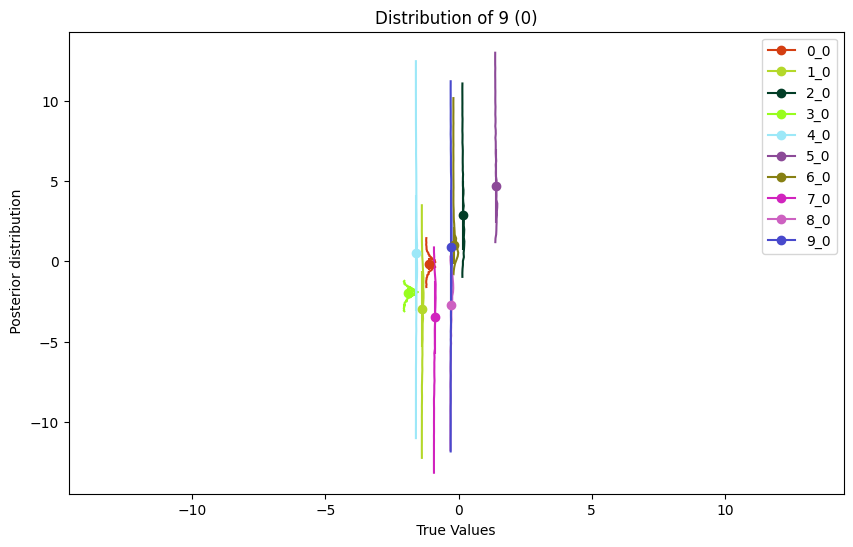

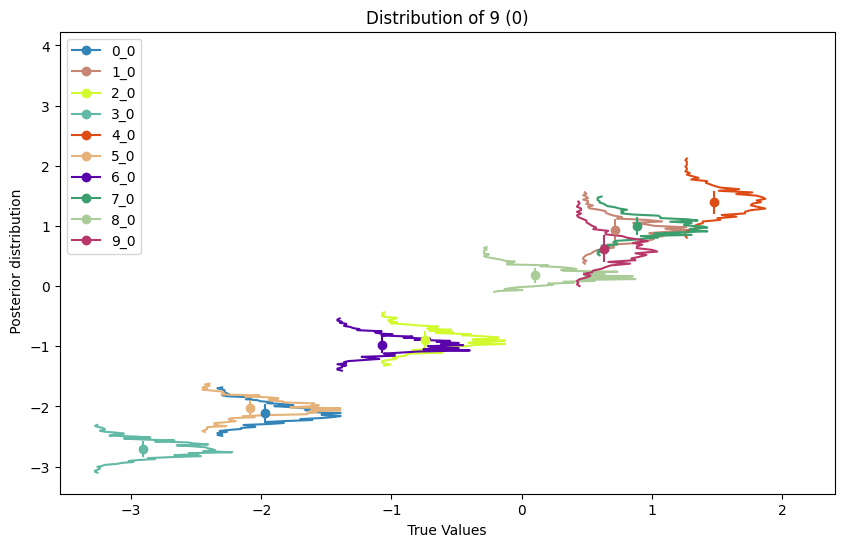

In [ ]:
alphas_social = bi.dist.uniform(-3, 3, sample = True, shape = (Nsim,), seed = 1)
alphas_asocial = bi.dist.uniform(-3, 3, sample = True, shape = (Nsim,), seed = 100)
sim3 = sim_estimations(alphas_asocial = alphas_asocial,alphas_social = alphas_social, file = 'sim3.csv')

## With covariates
Due to issues related to long tail posterior distribution for social rate when true social transmission rate is strong, we will fix social and asocial rates to a value that is not too strong but still present and incorporate covariates effects one by one and evaluate there correct estimation.

### Model with covariates
The intercept have its own prior set to 0, 5 as we specify a large prior (invert logit of 5 is 0.993). The covariates have their own priors set to 0, 1 as we consider them as scaled


In [ ]:
def model(D_asocial, D_social, network, status2 = None, status = None):
    if status is None:
        status = status2

    N = status.shape[0] # Number of individuals
    T = status.shape[1] # Number of time steps
    P = status.shape[2] # Number of processes

    lk = jnp.zeros((N,T, P))

    # Priors for social effect covariates
    alpha_soc = bi.dist.normal(0, 5, shape = (1,), sample=False, name='alpha_soc')
    betas_soc = bi.dist.normal(0, 1, shape = (D_social.shape[3]-1,), sample=False, name='betas_soc')
    soc = jnp.concatenate((alpha_soc, betas_soc))

    # Priors for asocial effect covariates
    alpha_asoc = bi.dist.normal(0, 5,  shape = (1,), sample=False, name='alpha_asoc')
    betas_asoc = bi.dist.normal(0, 1, shape = (D_asocial.shape[2]-1,), sample=False, name='betas_asoc')
    asoc = jnp.concatenate((alpha_asoc, betas_asoc))

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0, 0].set(theta)

    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t, 0].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status)

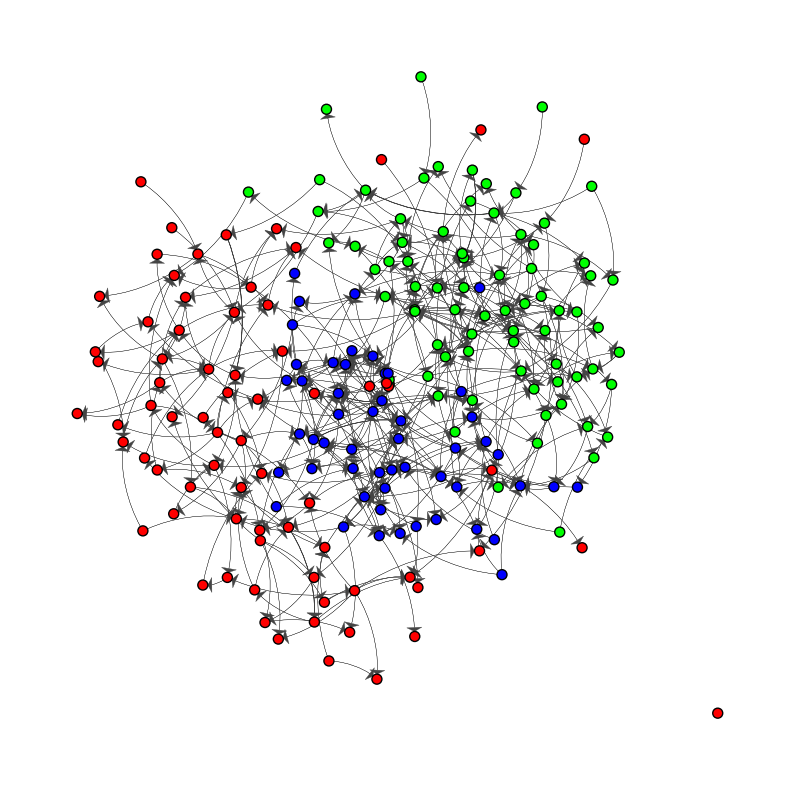

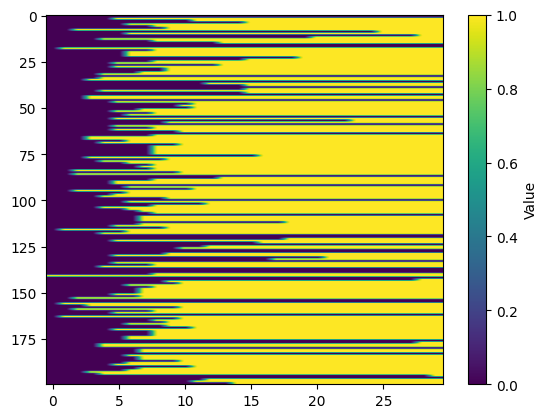

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.94it/s, 3 steps of size 8.06e-01. acc. prob=0.92] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


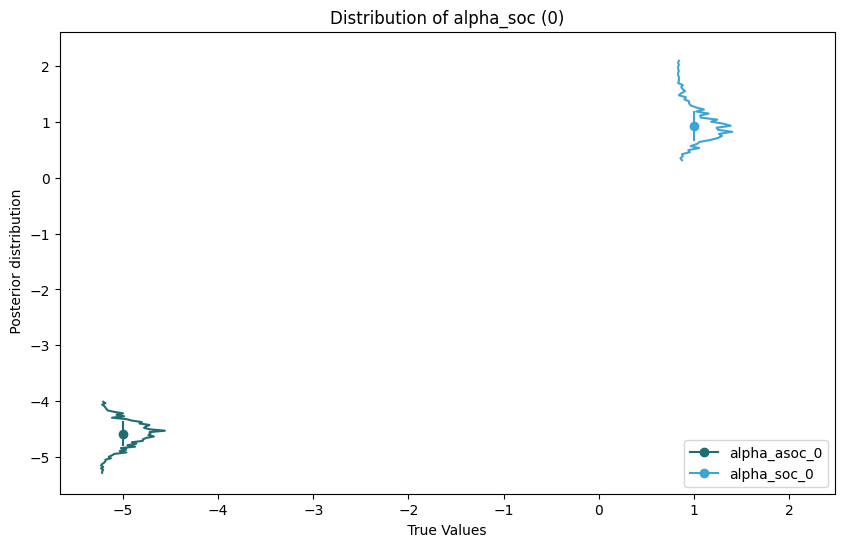

In [ ]:
nbdaObject, means, m, covariates_data = main(N = 200, 
                                             times = 30,
                                             alpha_social = jnp.array([1]), 
                                             alpha_asocial = jnp.array([-5]),
                                             print_network= True, print_status = True)
plot_distributions(m.posteriors,  dict(alpha_asoc=jnp.array([-5]), alpha_soc=jnp.array([1])))

So the main simulation data will always have asocial rate set to -5 (nonexistent) and so social rate set to 1 (0.75).



### Nodal Fixed covariate

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(covariates_data['covF'])) # ! Import nodal fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -1]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(covariates_data['covF']))
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], alpha_soc=[alpha_social[0]],
                                       betas_asoc =  alpha_asocial[1:], betas_soc = alpha_social[1:]), by_param = False)

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


warmup:   3%|▎         | 69/2000 [00:47<22:16,  1.45it/s, 7 steps of size 1.17e-01. acc. prob=0.77]  


KeyboardInterrupt: 

### Nodal time varying covariate
#### Scaling the covariate within each time steps

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0 ]) #! covNF will have an effect of 0 (i.e. 0.5) we need 2 coefficients, one for covNF_i and one for covNF_j
alpha_asocial =jnp.array([-5, -5, -5]) #! covNF will have an effect of -5 (i.e. noneexistent)
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


In [ ]:
NV_save = m 

#### QQ-plot

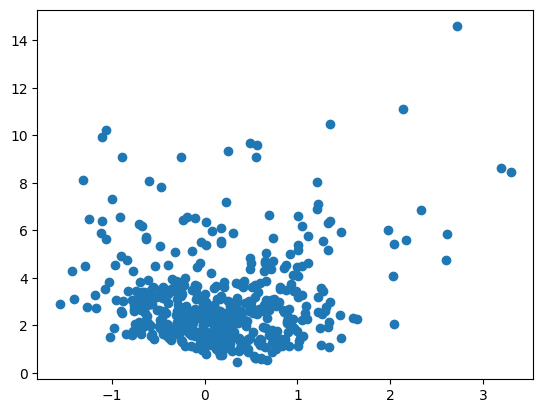

In [ ]:
plt.scatter(m.posteriors['betas_soc'][:,4], m.posteriors['alpha_soc'])

alpha_asoc


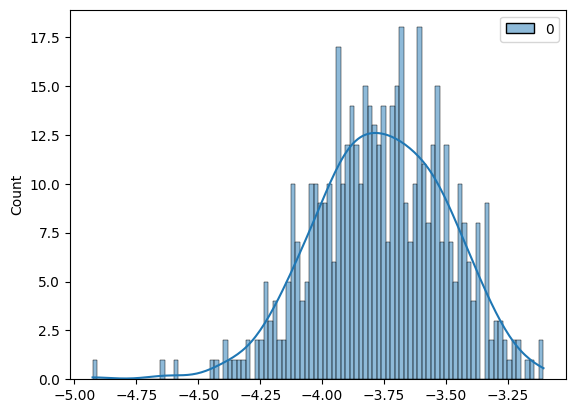

alpha_soc


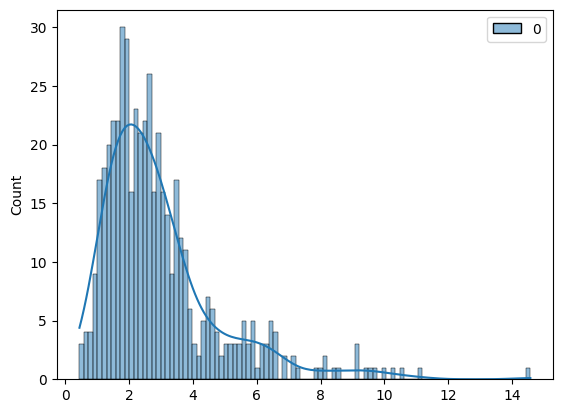

betas_asoc


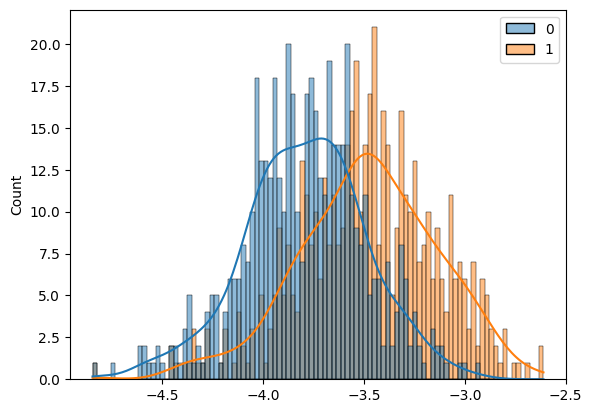

betas_soc


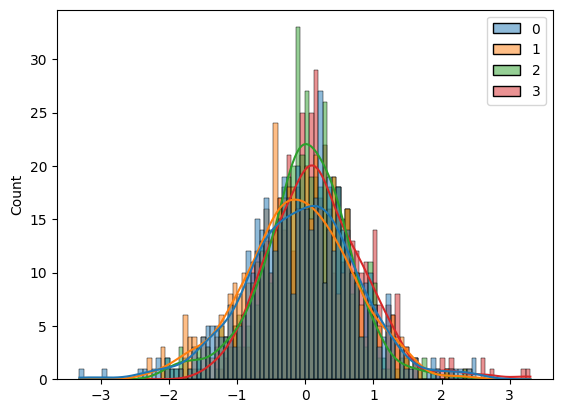

In [ ]:
for k in m.posteriors.keys():
    print(k)
    sns.histplot(m.posteriors[k], kde=True, bins = 100)
    plt.show()
    plt.close()

/tmp/ipykernel_218917/624485197.py:3: UserWarning: Sample's batch dimension size 500 is different from the provided 1000 num_samples argument. Defaulting to 500.
  predictive = Predictive(model, m.posteriors, num_samples=1000)


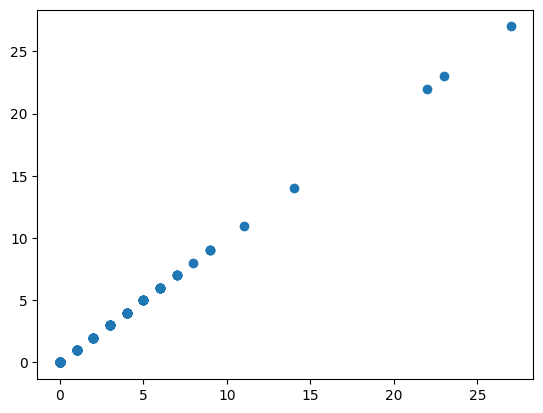

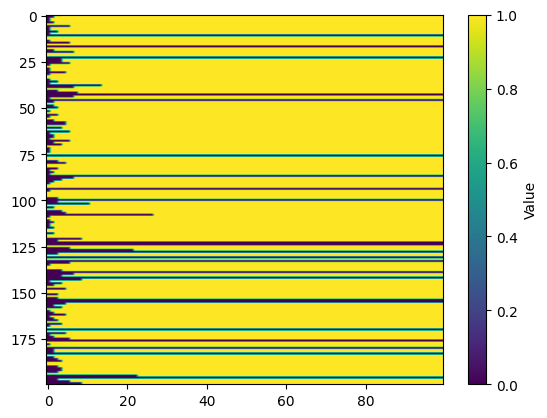

In [ ]:
from numpyro.infer import Predictive
def predict(model, m, nbdaObject):
    predictive = Predictive(model, m.posteriors, num_samples=1000)
    rng_key = jax.random.PRNGKey(1)
    preds = predictive(rng_key, D_asocial = nbdaObject.D_asocial, D_social = nbdaObject.D_social, network = nbdaObject.network, status2 = nbdaObject.status)

    meanPred = jnp.mean(preds['y'][:,:,:,0], axis=0)
    plt.scatter(jnp.argmax(nbdaObject.status, axis=1)[:,0],
            jnp.argmax(meanPred, axis=1))
    plt.show()
    heatmap(meanPred)
    return preds
preds = predict(model, m, nbda)

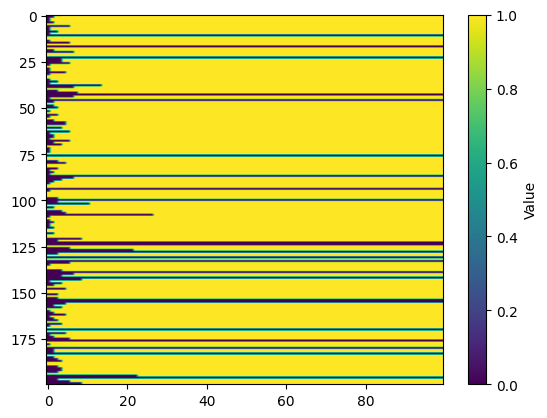

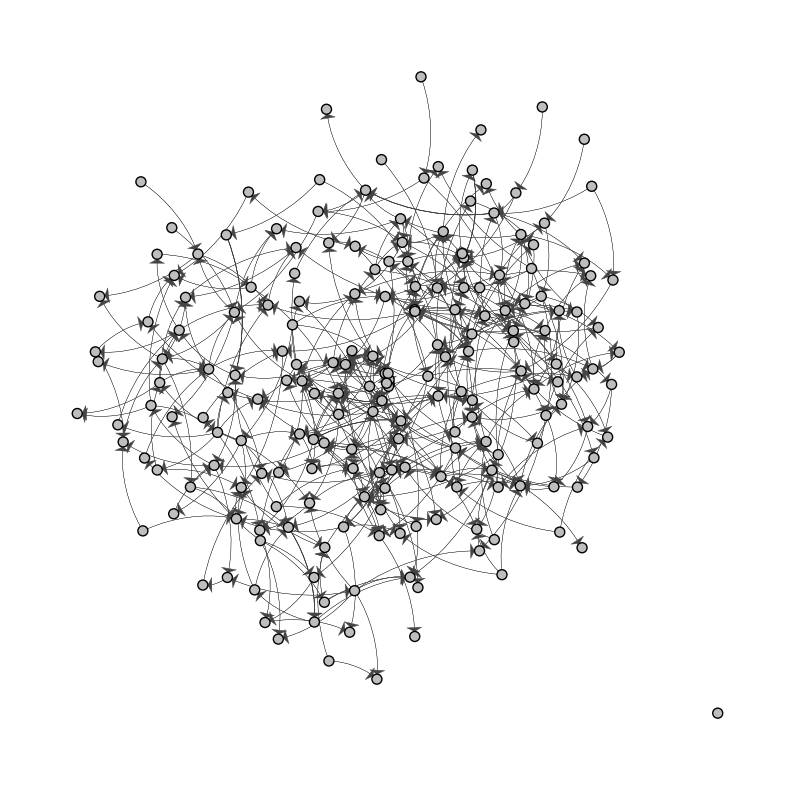

In [ ]:
heatmap(nbda.status)
viz_network(nbda.network[:,:,0,0], )

### Dyadic fixed covariate

Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, 7 steps of size 2.96e-01. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.13  0.29     -4.57      -3.66       0.02     0.01    325.14   
alpha_soc[0]   1.21  0.63      0.28       1.98       0.05     0.04    167.70   
betas_asoc[0] -3.70  0.30     -4.13      -3.19       0.02     0.01    321.17   
betas_asoc[1] -3.40  0.34     -3.97      -2.88       0.02     0.01    290.30   
betas_soc[0]  -0.46  0.55     -1.29       0.36       0.03     0.03    312.92   
betas_soc[1]   0.25  0.40     -0.39       0.83       0.03     0.02    272.93   
betas_soc[2]   0.04  0.41     -0.58       0.67       0.02     0.02    345.22   
betas_soc[3]   0.37  0.40     -0.21       0.89       0.02     0.02    427.31   
betas_soc[4]   0.60  0.76     -0.59       1.79       0.04     0.03    356.88   

               ess_tail  r_hat  
alpha_asoc[0]    470.50    NaN  
alpha_soc[0]     194.42    NaN  
betas_asoc[0]    384.65    NaN  
betas_asoc[1]    406.36    NaN  
betas_soc[0] 

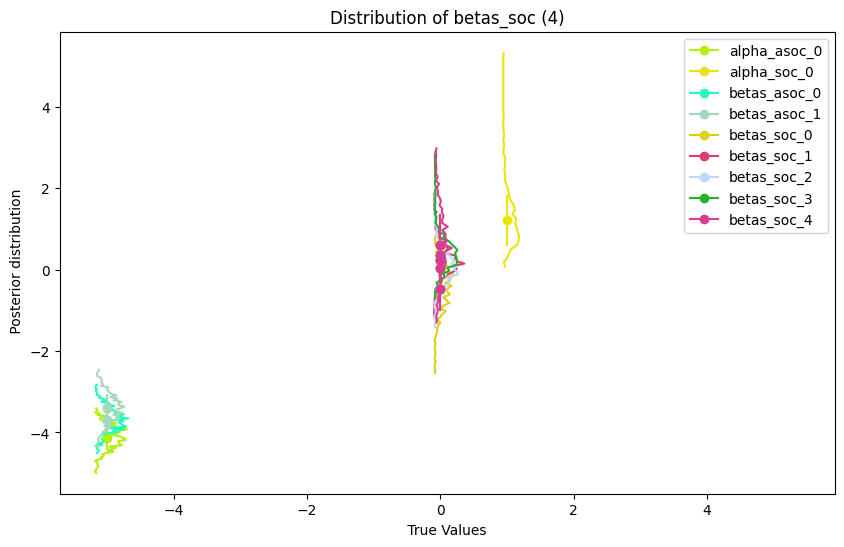

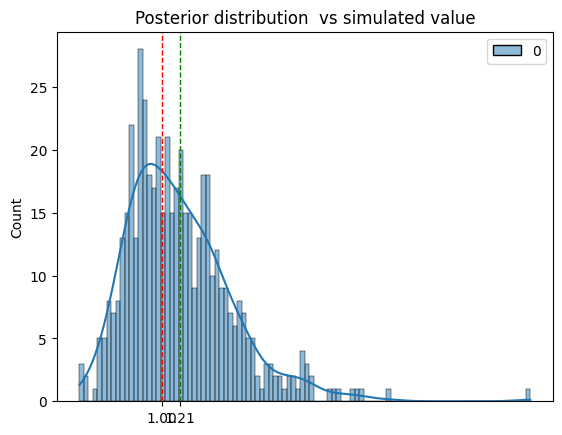

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0, 0]) #! Dyadic covariates already have i and j, so a single coefficient
alpha_asocial =jnp.array([-5, -5, -5]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


### Dyadic time-varying covariates
#### Scaling dyadic time-varying covariates

In [ ]:
import pandas as pd
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

# ! Dummy nbda object with no status to initialize data for the diffusion process
nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) # ! Import nodal fixed covariate data to affect diffusion process
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) # ! Import nodal time-varying covariate data to affect diffusion process
nbda.import_covDF(covariates_data['covDF'][:,:,0]) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.import_covDV(covariates_data['covDV']) # ! Import dyadic fixed covariate data to affect diffusion process
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1, 0, 0, 0, 0, 0, 0]) 
alpha_asocial =jnp.array([-5, -5, -5]) #! No dyadic covariates for asocial learning
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

#! update nbda object with diffusion process simulated 
nbda=NBDA(covariates_data['network'], status) 
nbda.import_covNF(pd.DataFrame(scale(covariates_data['covF']))) 
nbda.import_covNV(covariates_data['covV'][:,:times].reshape((-1,N,times))) 
nbda.import_covDF(covariates_data['covDF'][:,:,0])
nbda.import_covDV(covariates_data['covDV'])
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

## Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=[alpha_asocial[0]], betas_asoc=alpha_asocial[1:],
                                       alpha_soc=[alpha_social[0]], betas_soc=alpha_social[1:]), by_param = False)

kde(m.posteriors['alpha_soc'],  original_value=alpha_social[0])


Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed
jax.local_device_count 32


warmup:  30%|██▉       | 297/1000 [03:59<09:26,  1.24it/s, 7 steps of size 1.33e-01. acc. prob=0.78]  


KeyboardInterrupt: 

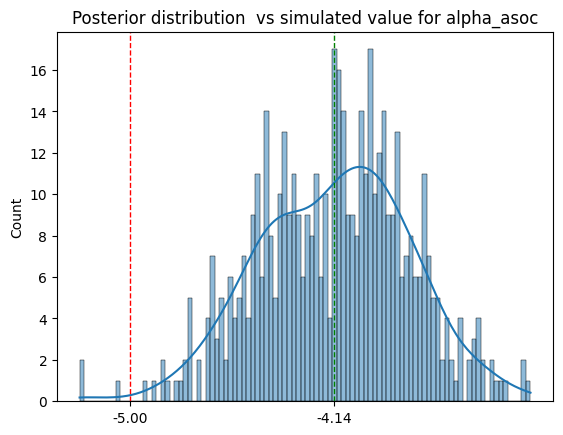

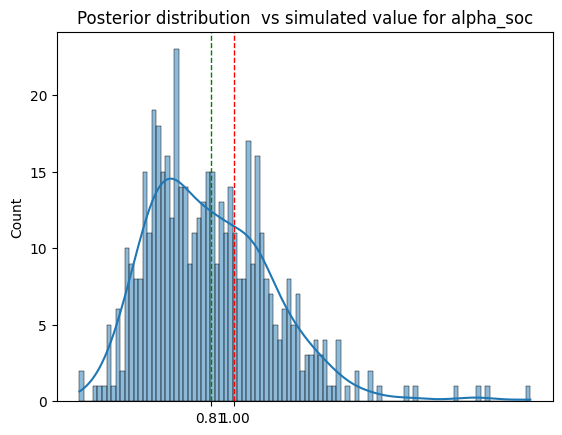

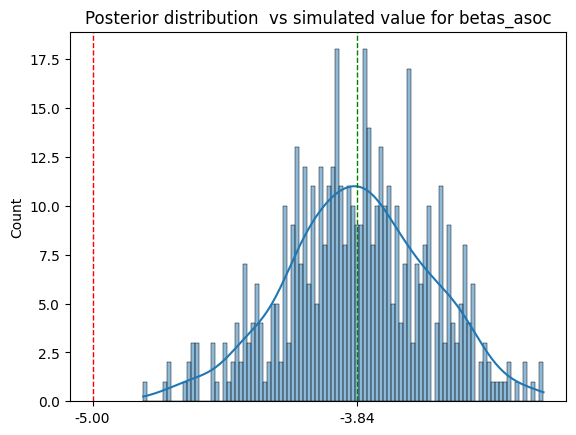

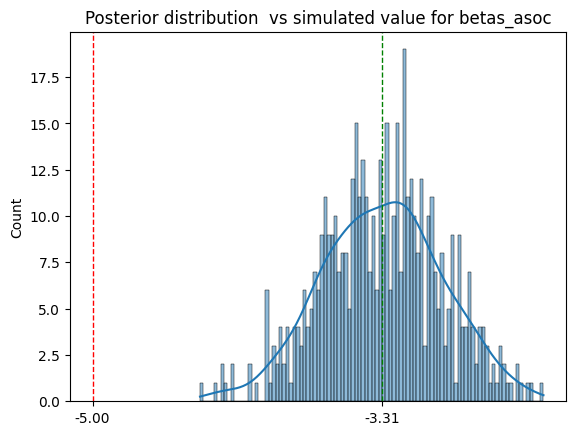

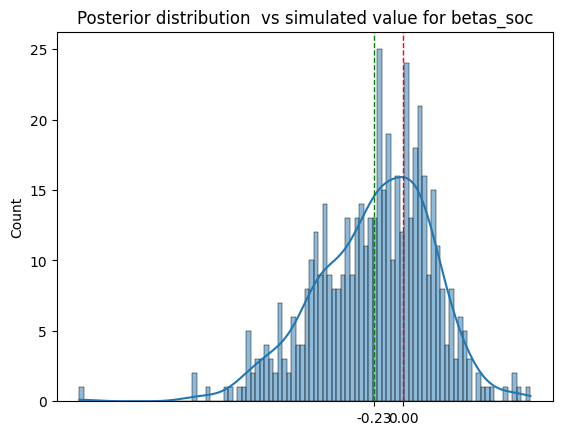

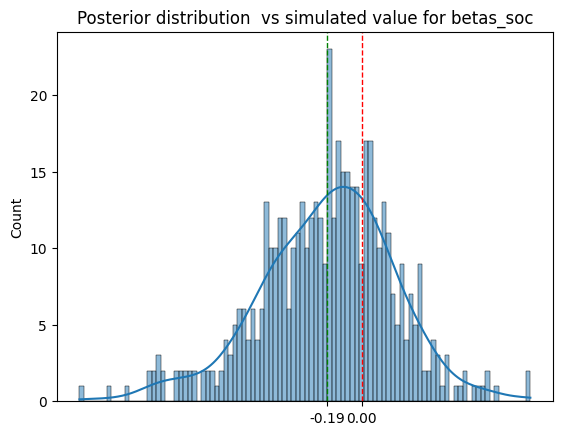

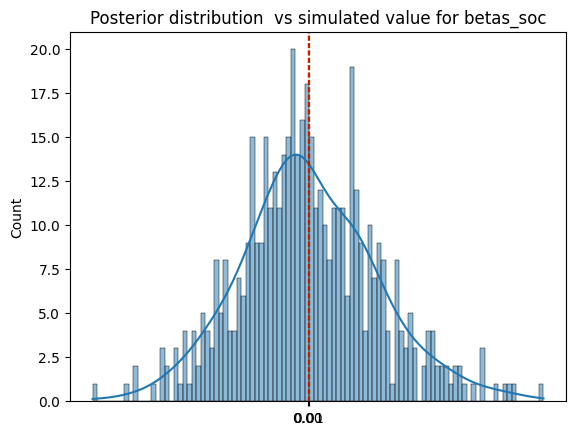

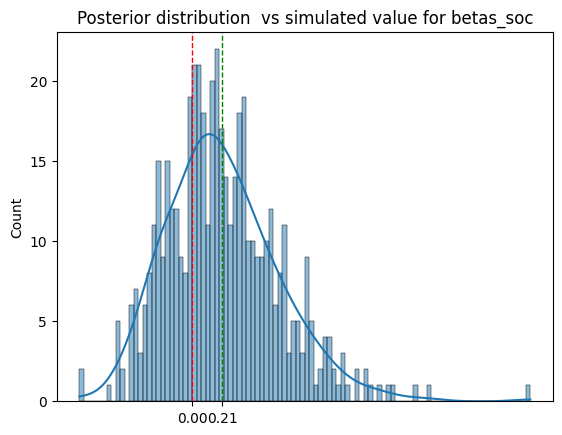

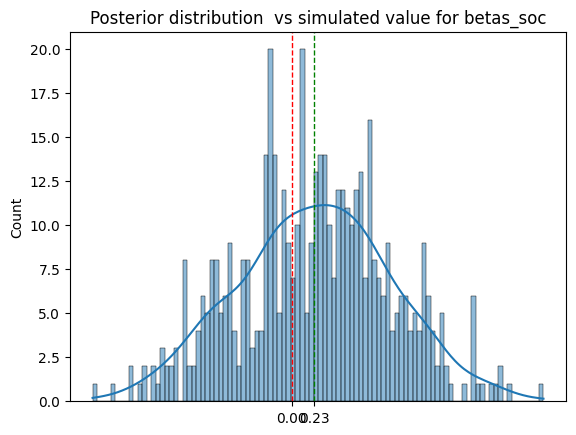

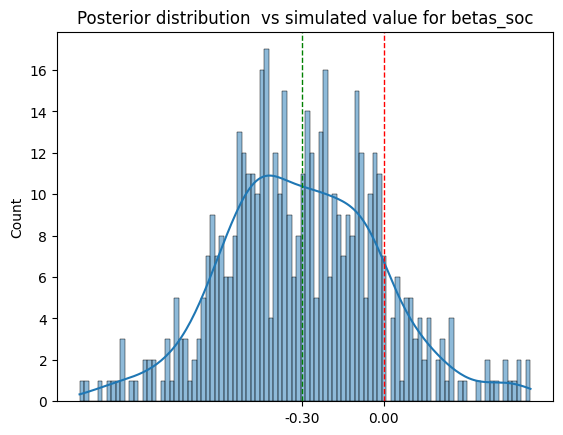

In [ ]:
params_kde(m, alpha_asocial=alpha_asocial, alpha_social= alpha_social)

## Testing R data

In [ ]:
import json
with open('R_data.json', 'r') as file:
    data = json.load(file)
data.keys()

dict_keys(['net', 'status', 'covDF1', 'covDF2', 'covNF1', 'covNF2'])

In [ ]:
rnet = jnp.array(data['net'])
print(rnet.shape)
rstatus = jnp.array(data['status'])
print(rstatus.shape)
covDF1 = jnp.array(data['covDF1'])
covDF1 = covDF1.at[jn]
print(covDF1.shape)
covDF2 = jnp.array(data['covDF2'])
print(covDF2.shape)
covDF = jnp.stack([covDF1, covDF2], axis = -1).reshape(100,100, 2)
print('covDF correct')
print(jnp.array_equal(covDF[:,:,0], covDF1))
covNF1 = jnp.array(data['covNF1'])
print(covNF1.shape)
covNF2 = jnp.array(data['covNF2'])
print(covNF2.shape)

rdf = pd.DataFrame(jnp.stack((covNF1, covNF2)).T)
rdf.head()

(100, 100)
(100, 200)
(100, 100)
(100, 100)
covDF correct
True
(100,)
(100,)


,0,1
0,-1.4612,0.0
1,1.5494,0.0
2,0.2454,0.0
3,-0.5237,0.0
4,-0.2347,0.0


In [ ]:
nbda=NBDA(rnet, rstatus) 
nbda.import_covNF(rdf) 
nbda.import_covDF(covDF)
nbda.get_cov()

m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=500, num_warmup=500, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)



jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s, 15 steps of size 1.75e-01. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Estimated parameters
               mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -5.85  0.31     -6.30      -5.30       0.02     0.01    255.08   
alpha_soc[0]  -8.17  0.70     -9.17      -7.00       0.05     0.04    182.96   
betas_asoc[0]  0.93  0.32      0.45       1.47       0.02     0.01    393.20   
betas_asoc[1] -0.68  0.72     -1.85       0.39       0.03     0.02    604.50   
betas_soc[0]  -1.81  0.28     -2.25      -1.39       0.02     0.01    253.63   
betas_soc[1]   1.47  0.37      0.83       1.98       0.02     0.02    309.58   
betas_soc[2]  -1.08  0.25     -1.51      -0.73       0.02     0.01    220.76   
betas_soc[3]   1.51  0.41      0.84       2.11       0.02     0.01    429.97   
betas_soc[4]  -0.26  0.88     -1.83       0.95       0.04     0.04    459.48   
betas_soc[5]   1.33  0.47      0.55       2.00       0.03     0.02    340.28   

               ess_tail  r_hat  
alpha_asoc[0]    297.75    NaN  
alpha_soc[0]     259.80    NaN  

In [ ]:
covDF1

Array([[ 1.  ,  0.02,  0.23, ..., -0.02,  0.16,  0.12],
       [ 0.02,  1.  ,  0.09, ...,  0.13,  0.13,  0.1 ],
       [ 0.23,  0.09,  1.  , ...,  0.13,  0.07, -0.23],
       ...,
       [-0.02,  0.13,  0.13, ...,  1.  , -0.02, -0.02],
       [ 0.16,  0.13,  0.07, ..., -0.02,  1.  ,  0.15],
       [ 0.12,  0.1 , -0.23, ..., -0.02,  0.15,  1.  ]], dtype=float64)

In [ ]:
bi.net.density(covDF1)

Array(1.01, dtype=float64)

alpha_asoc


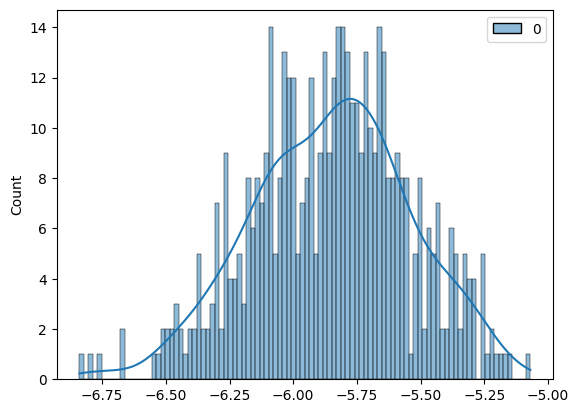

alpha_soc


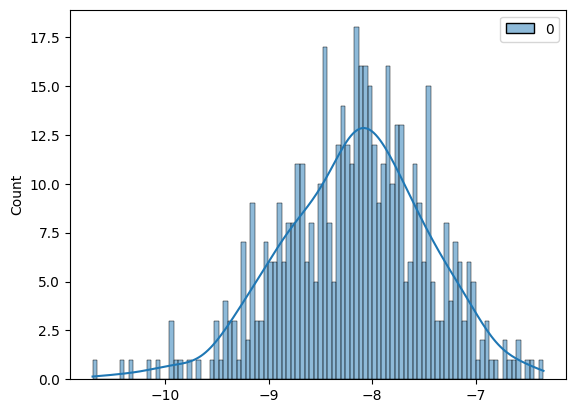

betas_asoc


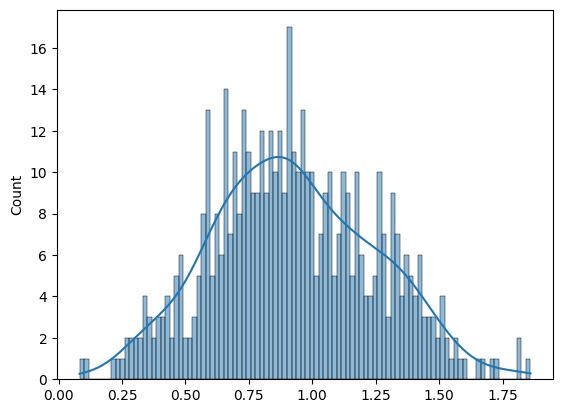

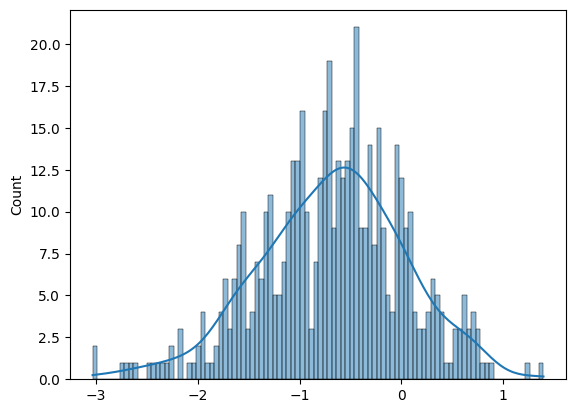

betas_soc


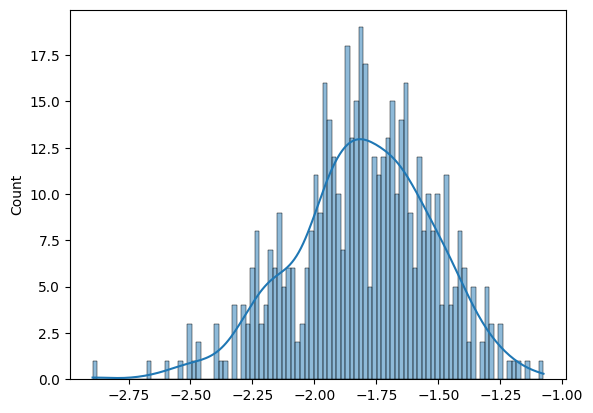

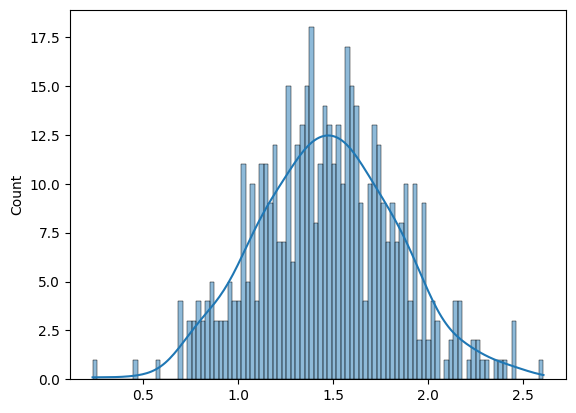

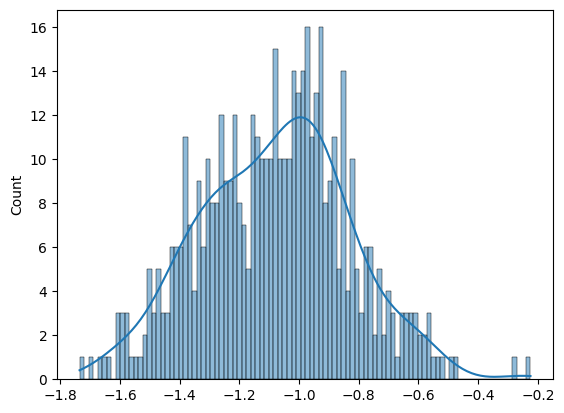

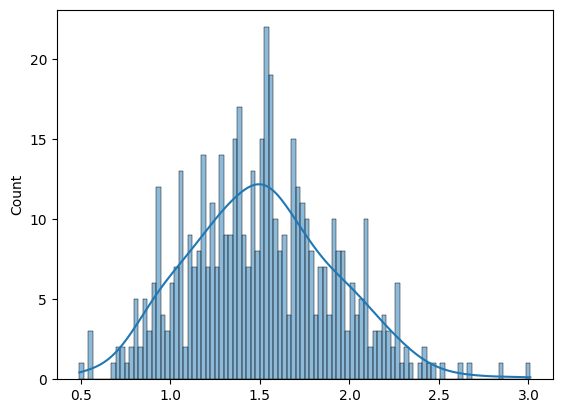

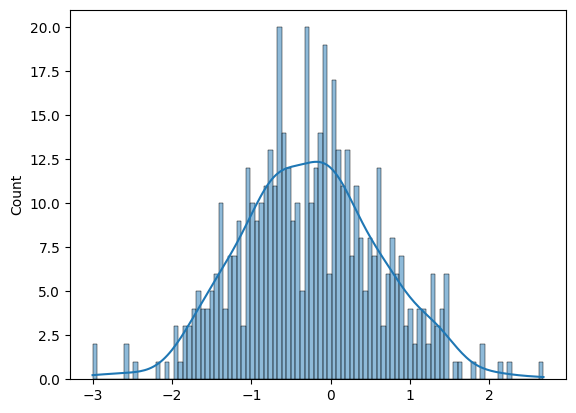

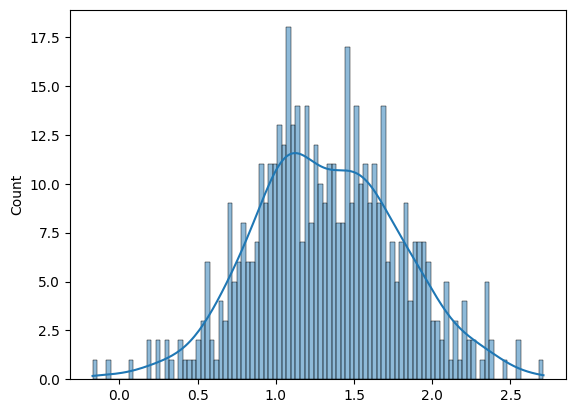

In [ ]:
for k in m.posteriors.keys():
    print(k)
    if m.posteriors[k].shape[1] == 1:
        sns.histplot(m.posteriors[k], kde=True, bins = 100)
        plt.show()
    else:
        for i in range(m.posteriors[k].shape[1]):
            sns.histplot(m.posteriors[k][:,i], kde=True, bins = 100)
            plt.show()


## Multiple categories of behaviors

# [Constant elasticity of substitution](https://en.wikipedia.org/wiki/Constant_elasticity_of_substitution) to account for directionality and rate of learning based on network links

$Q = F \cdot \left( a \cdot K^\rho + (1 - a) \cdot L^\rho \right)^{\frac{\nu}{\rho}}$

where: 

- Q = Quantity of output

- F = Total Factor Productivity

- a = Share parameter

- K,L = Quantities of primary production factors (Capital and Labor)
 
- ρ = (σ − 1)/σ = Substitution parameter

- σ = 1/(1 - ρ) = [Elasticity of substitution](https://en.wikipedia.org/wiki/Elasticity_of_substitution)

- υ = degree of homogeneity of CES function. Where v = 1 (Constant return to scale),  υ  < 1 (Decreasing return to scale), υ > 1 (Increasing return to scale).


In [ ]:
import jax
@jax.jit
def ces(K,L, alpha, sigma, upsilon = 1):
    """
    Compute the Constant Elasticity of Substitution (CES) function:
    
        Q = 2 * (a * K**rho + (1 - a) * L**rho) ** (v / rho)
    
    where:
        - K represents the original network (outgoing ties).
        - L represents the transposed network (incoming ties).
        - rho is the substitution parameter, defined as (sigma - 1) / sigma.
        - The factor of 2 is included to recover links weigth as if a = 0.5 we get:  network/2 + network.T/2

    Parameters:    
      K (2D array): Represents the original network, capturing outgoing ties. 
      L (2D array): Represents the transposed network, capturing incoming ties.
      alpha (float): **Share parameter**, controlling the relative importance of K and L. *A higher alpha increase the weight of K, while a lower alpha emphasis L*.
      sigma (float): **Elasticity of substitution**, Indicates how easily K and L can be substituted for one another.
                - if sigma approach 0, K and L are perfect complements (i.e. K can't be replaced by L and vice versa, directionality do matter).
                - if sigma approach 1, the function resembles a Cobb-Douglas form, indicating unitary elasticity (i.e. K and L can be replaced using a constant, XXX).
                - if sigma approaches infinity, K and L are perfect substitutes (i.e. K can be replaced by L and vice versa, directionality do not matter).

      upsilon (float): **Degree of homogeneity** of the CES function (probability of learning based on changes on network weigths):
                 - v = 1: Constant returns to scale (i.e. proportionally scaling K and L will scale the output (learning from links weigths) by the same scaling factor)
                 - v < 1: Decreasing returns to scale (i.e. scaling all K and L will scale the output (learning from links weigths) by less than the scaling factor)
                 - v > 1: Increasing returns to scale (i.e. scaling all K and L will scale the output (learning from links weigths) by more than the scaling factor)

    Returns:
      2D array: The computed CES output for each element in the network.
    """ 
    sigma = (3.1415/3.1415926)*sigma
    rho = (sigma - 1)/sigma
    Q = (alpha * K**rho + (1 - alpha) * L**rho)**(upsilon/rho) # ! *2 to recover 
    #jax.debug.print("Q: {}", Q)
    return Q

## Updating diffusion simulation

In [25]:
import random as random2

def diffusion2(data, alpha_social, alpha_asocial, CES = False,  alpha = None, sigma = None):
    D_social = data.D_social
    D_asocial = data.D_asocial
    informed = jnp.zeros((data.n,  data.t), dtype=int)

    # Asocial learning only at t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], alpha_asocial, axes=(-1, 0))
    theta = m.link.inv_logit(R_asocial)

    # Informed update at t = 0-----------------------
    informed = informed.at[:,0].set(m.dist.binomial(total_count=jnp.ones(theta.shape[0], dtype=int), probs = theta, sample=True, seed = random2.randint(0,10000)))

    for t in range(1,data.t):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], alpha_social, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)        
        

        if CES:
            if any(x is None for x in [alpha, sigma]):
                raise ValueError("If CES is True, v, a, and sigma must be provided.")
            elasticity = phi*ces(data.network[:,:,t,0], data.network[:,:,t,0].T, alpha, sigma)
            social_influence_weight = inv_logit2(jnp.tensordot(elasticity[:,:], informed[:,t-1], axes=(-1, 0)))

        else:
            attention_weigthed_network = phi*data.network[:,:,t,0]
            social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], informed[:,t-1], axes=(-1, 0)))
            

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], alpha_asocial, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)

        # Informed update at t!= 0-----------------------
        p = theta + (1-theta)*social_influence_weight

        informed =  informed.at[:,t].set(jnp.where(informed[:, t-1] == 1, 1, m.dist.binomial(total_count=jnp.ones(p.shape[0], dtype=int),probs = p, sample=True, seed = random2.randint(0,10000))))

    return informed

In [ ]:
N=200 # Number of individuals
times=100 # number of time steps
m = bi(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion2(nbda, alpha_social, alpha_asocial, CES = True, alpha = 1, sigma = 10) # Simulate difussion
heatmap(status)

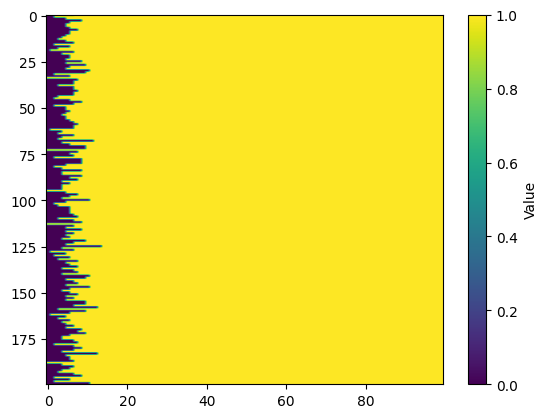

## Updating model

In [63]:
import numpyro
def modelCES(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    ces_alpha = m.dist.beta(2,2, name = 'ces_a')
    ces_sigma = m.dist.halfcauchy(1, name = 'ces_sigma')

    
    # Priors for social effect covariates
    soc = m.dist.normal(0, 2, shape = (1,), sample=False, name='alpha_soc')

    # Priors for asocial effect covariates
    asoc = m.dist.normal(0, 2, shape = (1,), sample=False, name='alpha_asoc')

    # Asocial learning -----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc, axes=(-1, 0))    
    theta = m.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)


    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc, axes=(-1, 0))
        phi = m.link.inv_logit(R_social)
        
        elasticity = ces(network[:,:,t,0], network[:,:,t,0].T, ces_alpha, ces_sigma)
        attention_weigthed_network = phi*elasticity
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))


        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc, axes=(-1, 0))
        theta = m.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

## Testing CES approach

jax.local_device_count 32
Simulated network with N =  200
Simulated diffusion  with rows representing individuals  200  and columns representing time steps. 1 = informed, 0 = uninformed


$$
        \text{Informed} = \text{Binomial}(\text{LK}) \newline
        \text{LK} = \left[ \theta + (1-\theta)S \right] (1- z_i) \newline
        \theta = \alpha_a \newline
        S = \alpha_s \left( \sum_{j = 1}^{N} A_{ij} z_{j} \right) \newline 
        \alpha_a\sim Normal(0,4) \newline
        \alpha_s \sim Normal(0,4) \newline
        $$

$$ \text{Informed} = Asocial Rate + Social Rate \newline$$

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [02:08<00:00, 15.53it/s, 15 steps of size 2.03e-01. acc. prob=0.87]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/home/sosa/.local/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Estimated parameters
               mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_asoc[0] -4.91   0.44     -5.62      -4.23       0.02     0.02    433.74   
alpha_soc[0]   2.30   0.85      1.16       3.70       0.06     0.04    251.60   
ces_a          0.09   0.04      0.02       0.15       0.00     0.00    459.21   
ces_sigma      6.79  25.44      1.17      10.20       1.53     1.09    249.07   

               ess_tail  r_hat  
alpha_asoc[0]    437.08    NaN  
alpha_soc[0]     217.24    NaN  
ces_a            245.24    NaN  
ces_sigma        217.75    NaN  


array([[<Axes: ylabel='alpha_asoc\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_soc\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='ces_a'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_asoc\n0', ylabel='ces_sigma'>, <Axes: xlabel='alpha_soc\n0'>, <Axes: xlabel='ces_a'>, <Axes: xlabel='ces_sigma'>]], dtype=object)

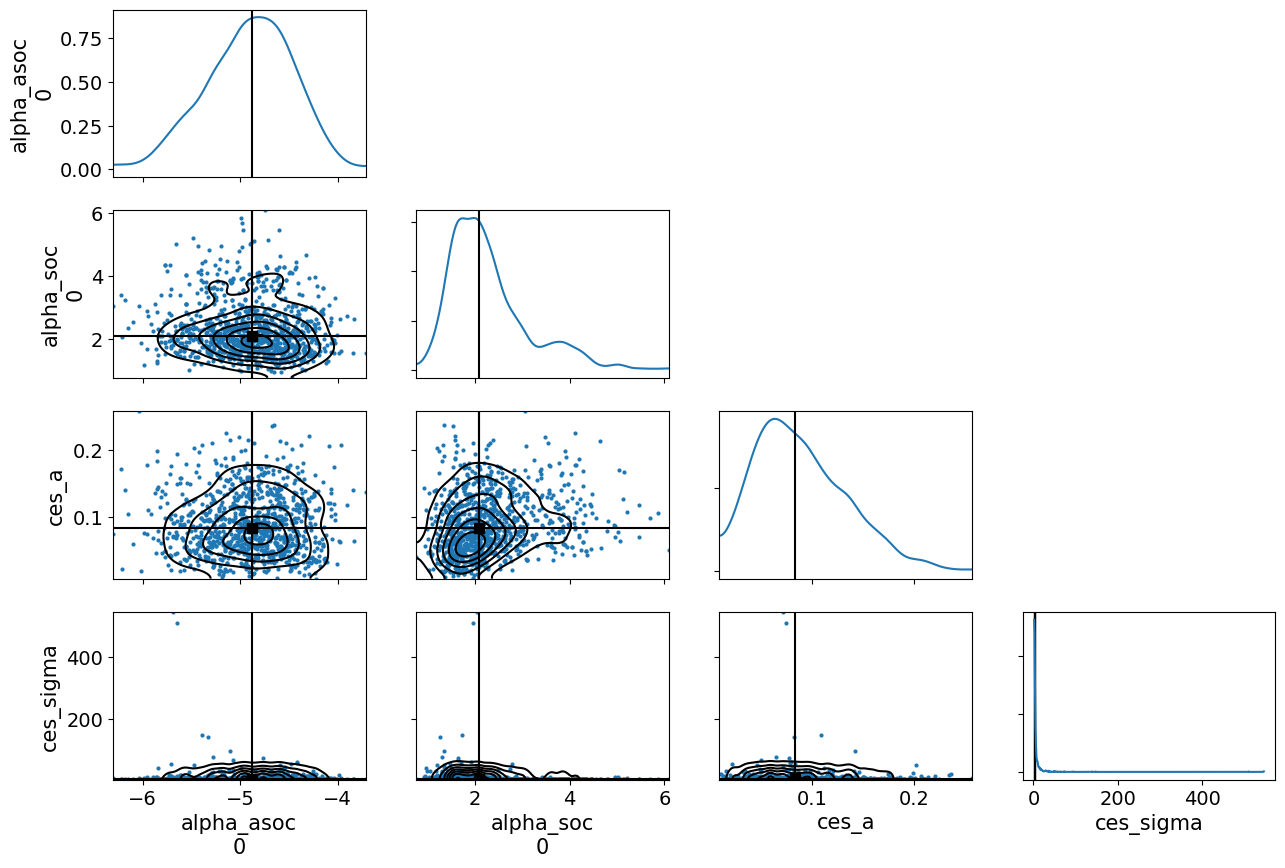

In [64]:
N=200 # Number of individuals
times=30 # number of time steps
m = bi(platform='cpu')
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status_sim = diffusion2(nbda, alpha_social, alpha_asocial, CES = True, alpha = 0.1, sigma =  10)

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status_sim)


nbda2=NBDA(covariates_data['network'], status_sim)
nbda2.get_cov()
nbda2.print_model()

# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda2.D_asocial, D_social = nbda2.D_social, network = nbda2.network, status = nbda2.status)
m.run(modelCES, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

m.diag_pair(figsize = (15, 10))

# Joint model of SRM+BLOCK with NBDA

# Time varying coefficients

In [ ]:
def coefficients(V, T,
                mu_mu =  0,
                mu_sigma = 1,
                sigma_mu = 1,
                sample = False,
                name = 'betas_soc'):
    """
    Generates time-varying coefficients using hierarchical normal distributions.

    Args:
        V (int): Number of coefficients.
        T (int): Number of time points.
        mu_mu (float, optional): Mean of the Mu_betas distribution. Defaults to 0.0.
        mu_sigma (float, optional): Mean of the Sigma_betas distribution. Defaults to 1.
        sigma_mu (float, optional): Standard deviation of the Mu_betas distribution. Defaults to 1.
        name (str, optional): Name for identification. Defaults to 'betas_soc'.

    Returns:
        Tensor: A tensor of shape (T, V) representing time-varying coefficients.

    Distribution Details:
        - Mu_betas: Normal distribution with mean=mu_mu and std=sigma_mu
        - Sigma_betas: Normal distribution with mean=mu_sigma and std=sigma_sigma
        - betas: Normal distribution with mean=Mu_betas and std=Sigma_betas
    """

    Mu_betas = bi.dist.normal(mu_mu, mu_sigma, shape = (V,), sample=sample, name='Mu_'+name)
    Sigma_betas = bi.dist.exponential(sigma_mu, shape = (V,), sample=sample, name='Sigma_'+name)
    betas = bi.dist.normal(Mu_betas, Sigma_betas, shape = (T,), sample=sample, name='betas_'+name).reshape(T, V)
    return betas

coefficients(4, 10, sample = True) # 4 variables 10 time points

## Model

In [ ]:
def model(D_asocial, D_social, status, network):
    N = status.shape[0]
    T = status.shape[1]
    lk = jnp.zeros((N,T))

    # Priors for social effect covariates
    soc = coefficients(1, T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_soc')
    # Priors for asocial effect covariates
    asoc = coefficients(1,  T, mu_mu =  0, mu_sigma = 5, sigma_mu = 1, name = 'alpha_asoc')
    # Asocial learning for time t = 0-----------------------
    R_asocial = jnp.tensordot(D_asocial[:,0,:], asoc[0, :].reshape(1,), axes=(-1, 0))
    theta = bi.link.inv_logit(R_asocial)
    lk = lk.at[:,0].set(theta)



    for t in range(1,T):
        ## Social learning-----------------------
        R_social = jnp.tensordot(D_social[:,:,t,:], soc[t, :].reshape(1,), axes=(-1, 0))
        phi = bi.link.inv_logit(R_social)
        attention_weigthed_network = phi*network[:,:,t,0]
        social_influence_weight = inv_logit2(jnp.tensordot(attention_weigthed_network[:,:], status[:,t-1], axes=(-1, 0)))
        #status_network = jnp.tensordot(network[:,:,t,0], status[:,t-1], axes=(-1, 0))
        #attention_weigthed_network = phi[0,:]*status_network
        #social_influence_weight = inv_logit2(attention_weigthed_network)

        ## Asocial learning -----------------------
        R_asocial = jnp.tensordot(D_asocial[:,t,:], asoc[t, :].reshape(1,), axes=(-1, 0))
        theta = bi.link.inv_logit(R_asocial)
        
        # Informed update at t!= 0-----------------------
        lk = lk.at[:,t].set(jnp.where(status[:, t-1][:,0] == 1, jnp.nan, theta + (1-theta)*social_influence_weight[:,0]))

    mask = ~jnp.isnan(lk)
    with numpyro.handlers.mask(mask=mask): 
        #m.binomial(probs=lk, obs=status[:,:,0])
        numpyro.sample("y", numpyro.distributions.Binomial(probs=lk), obs=status[:,:,0])

## Running a single simulation 
No covariates, only asocial and social intercept.

In [ ]:
N=200 # Number of individuals
times=100 # number of time steps
print("Simulated network with N = ", str(N))
covariates_data = create_covariates(N=N, times=times, print_network= False,
                                    b_ij_mean1 = 0.2, b_ij_sd1 = 0.01, b_ii_mean1 = 0.2, b_ii_sd1 = 0.01,
                                    b_ij_mean = 0.02, b_ij_sd = 0.01, b_ii_mean = 0.2, b_ii_sd = 0.01) # Create covariates'

nbda=NBDA(covariates_data['network'], jnp.zeros((N,times))) # Initialyze nbda class with dummy status
nbda.get_cov()

# Set simulation parameters (those to recover)
alpha_social = jnp.array([1])
alpha_asocial =jnp.array([-5])
status = diffusion(nbda, alpha_social, alpha_asocial) # Simulate difussion

print("Simulated diffusion  with rows representing individuals ", str(N), " and columns representing time steps. 1 = informed, 0 = uninformed")
#heatmap(status)

nbda=NBDA(covariates_data['network'], status) 
nbda.get_cov()


# Run model to recover parameters
m = bi()
m.data_on_model=dict(D_asocial = nbda.D_asocial, D_social = nbda.D_social, network = nbda.network, status = nbda.status)
m.run(model, num_samples=1000, num_warmup=1000, num_chains=1, seed=0) 
summary = m.summary(kind = 'all')
print("Estimated parameters")
print(summary)

# Plot results
plot_distributions(m.posteriors,  dict(alpha_asoc=alpha_asocial, alpha_soc=alpha_social), by_param=False)

In [ ]:
summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mu_alpha_asoc[0],-5.12,0.21,-5.42,-4.77,0.03,0.02,70.98,219.90,NaN
Mu_alpha_soc[0],1.60,0.85,0.51,2.92,0.31,0.23,11.71,22.67,NaN
Sigma_alpha_asoc[0],0.49,0.26,0.13,0.84,0.07,0.05,14.31,75.67,NaN
Sigma_alpha_soc[0],1.24,0.80,0.22,2.31,0.48,0.39,2.38,24.79,NaN
betas_alpha_asoc[0],-5.39,0.58,-6.21,-4.55,0.06,0.05,107.25,341.10,NaN
...,...,...,...,...,...,...,...,...,...
betas_alpha_soc[95],1.60,1.68,-0.73,4.66,0.23,0.25,69.99,83.85,NaN
betas_alpha_soc[96],1.50,1.63,-0.99,4.11,0.16,0.27,115.41,42.62,NaN
betas_alpha_soc[97],1.56,1.62,-0.52,4.21,0.30,0.27,70.54,38.28,NaN
betas_alpha_soc[98],1.56,1.78,-0.69,4.31,0.19,0.24,94.82,47.25,NaN


In [ ]:
temporalCoeff = m 

In [ ]:
for k in m.posteriors.keys():
    print(k)
    print(m.posteriors[k].mean())

Mu_alpha_asoc
-5.121081461123768
Mu_alpha_soc
1.5972383130353356
Sigma_alpha_asoc
0.49218145223983767
Sigma_alpha_soc
1.2443165282206567
betas_alpha_asoc
-5.120433623681624
betas_alpha_soc
1.592933659770799


In [ ]:
tmp = dict(betas_alpha_soc = m.posteriors['betas_alpha_soc'], betas_alpha_asoc = m.posteriors['betas_alpha_asoc'])
plot_distributions(tmp,  dict(betas_alpha_soc=alpha_asocial, betas_alpha_asoc=alpha_social), by_param=False)

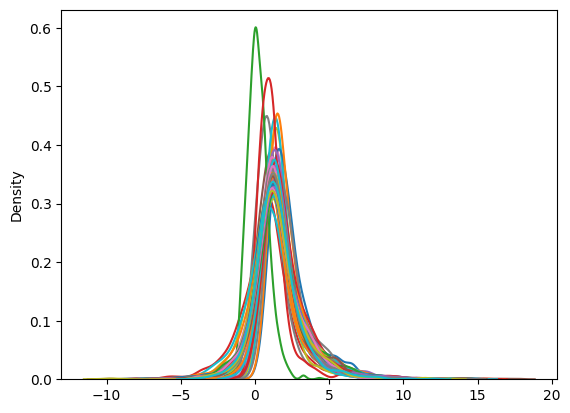

In [ ]:
for i in range(m.posteriors['betas_alpha_soc'].shape[1]):
    sns.kdeplot(m.posteriors['betas_alpha_soc'][:,i])


## With multiple processes
